# Hackathon Challenge ITADATA 2024: <br>Predicting Customer Creditworthiness

### Objective Level 1
Analyze the provided dataset of bank customers and build a predictive
model to determine the likelihood of a customer repaying their debt.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
sns.set_style("darkgrid")

In [2]:
df = pd.read_csv("training.csv", engine="c")

# Data Exploration

Let's see some quicly info about the dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2056160 entries, 0 to 2056159
Data columns (total 44 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   client_id                     int64  
 1   product8                      int64  
 2   product10                     int64  
 3   product13                     int64  
 4   product12                     int64  
 5   product11                     int64  
 6   product4                      int64  
 7   product17                     int64  
 8   product2                      int64  
 9   product3                      int64  
 10  product1                      int64  
 11  product7                      int64  
 12  product6                      int64  
 13  product5                      int64  
 14  product14                     int64  
 15  product15                     int64  
 16  product16                     int64  
 17  product9                      int64  
 18  has_products          

Another important question is how many unique client there are.

There are 102808 clients


<Axes: >

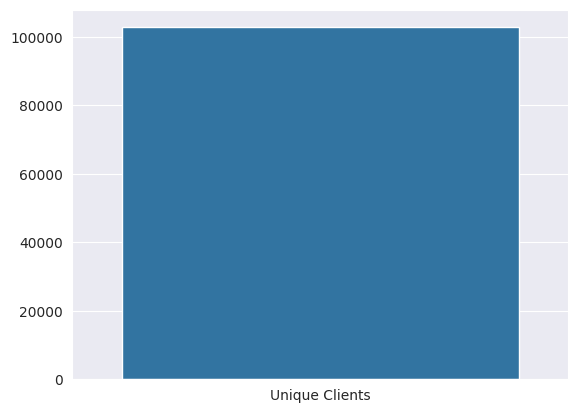

In [4]:
print(f'There are {df["client_id"].unique().size} clients')
sns.barplot(x=['Unique Clients'], y=[df['client_id'].nunique()])

The column "repays_debt" indicate if the client is good (0) or bad (1). Let's see how many good and bad clients there are.

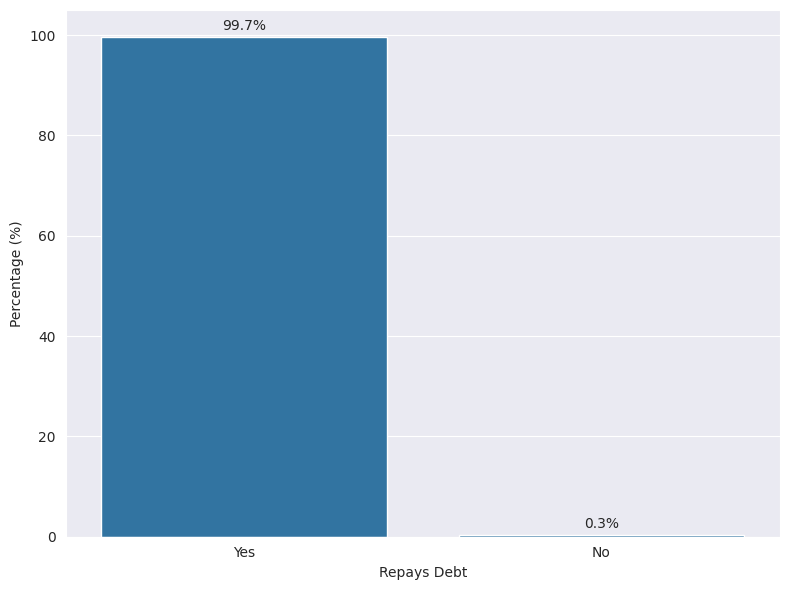

In [5]:
percentages = df['repays_debt'].value_counts(normalize=True) * 100
percentages_df = pd.DataFrame({
    'repays_debt': percentages.index,
    'percentage': percentages.values
})

plt.figure(figsize=(8, 6))
ax = sns.barplot(data=percentages_df, x='repays_debt', y='percentage')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', xytext=(0, 8), textcoords='offset points')

plt.xlabel('Repays Debt')
plt.ylabel('Percentage (%)')
plt.ylim(0, 105)
plt.xticks(ticks=[0, 1], labels=['Yes', 'No'])
plt.tight_layout()
plt.show()

We noticed the classes are so unbalanced, this could lead to a model that fails to be able to distinguish class 1, in particular:

In [6]:
f"The class 0 is around{df['repays_debt'].value_counts()[0] / df['repays_debt'].value_counts()[1] : .2f} times biggger than 1"

'The class 0 is around 306.53 times biggger than 1'

Then, to better understand the meaning of each columns, we decide to analyze the dataset only for the first client.

In [7]:
df_first = df[df["client_id"] == df["client_id"].iloc[38]]
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
df_first[numeric_columns]

,client_id,product8,product10,product13,product12,product11,product4,product17,product2,product3,...,counter_num_inbound,counter_num_outbound,securities_operations,securities_bought,securities_sold,counter_amt_tot,counter_num_tot,period,category,repays_debt
20,1,0,0,0,0,0,0,0,0,1,...,1,1,0,0,0,-21.638684,2,1,3,0
21,1,0,0,0,0,0,0,0,0,0,...,2,2,0,0,0,1982.191502,4,2,3,0
22,1,0,1,1,0,0,0,0,0,1,...,5,5,0,0,0,-129.807941,10,3,3,0
23,1,1,0,0,0,0,0,0,0,1,...,5,6,0,0,0,1686.161432,11,4,3,0
24,1,0,0,0,1,0,0,0,0,1,...,2,4,0,0,0,1.506562,6,5,3,0
25,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0.000000,0,6,3,0
26,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0.000000,0,7,3,0
27,1,1,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0.000000,0,8,3,0
28,1,0,1,1,0,0,1,0,1,0,...,0,0,0,0,0,0.000000,0,9,3,0
29,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0.000000,0,10,3,0


We understand that for each customer, the values of incoming and outgoing transfers are considered, split between two sources (‘wire_transfers1_amt_inbound’, ‘wire_transfers2_amt_inbound’ for incoming and ‘wire_transfers1_amt_outbound’, ‘wire_transfers2_amt_outbound’ for outgoing). These characteristics are associated with the respective counts, i.e. the number of wire transfers made ("wire_transfers*_num_inbound", "wire_transfers*_num_outbound"). And there is also a column wchich sum up these last two columns.

Over-the-counter transactions are also taken into account, both deposits (‘counter_amt_inbound’) and withdrawals (‘counter_amt_outbound’), with their respective counts (‘counter_num_inbound’ and ‘counter_num_outbound’). Also for these exists a column wchich sum up them. Instead, "counter_amt_tot" is the sum of "counter_amt_inbound" and "counter_amt_outbound".

Then we look for missing values.

In [8]:
df.isna().sum()

client_id                       0
product8                        0
product10                       0
product13                       0
product12                       0
product11                       0
product4                        0
product17                       0
product2                        0
product3                        0
product1                        0
product7                        0
product6                        0
product5                        0
product14                       0
product15                       0
product16                       0
product9                        0
has_products                    0
balance                         0
left_bank                       0
joined_bank                     0
wire_transfers2_amt_inbound     0
wire_transfers1_amt_inbound     0
wire_transfers2_amt_outbound    0
wire_transfers1_amt_outbound    0
counter_amt_inbound             0
counter_amt_outbound            0
securities_bought_amt           0
securities_sol

There are no missing values.

We check the balance distribution according to ‘repays_debt’. Since we noticed an imbalance before, we are interested to find out if it also happens with this feature.

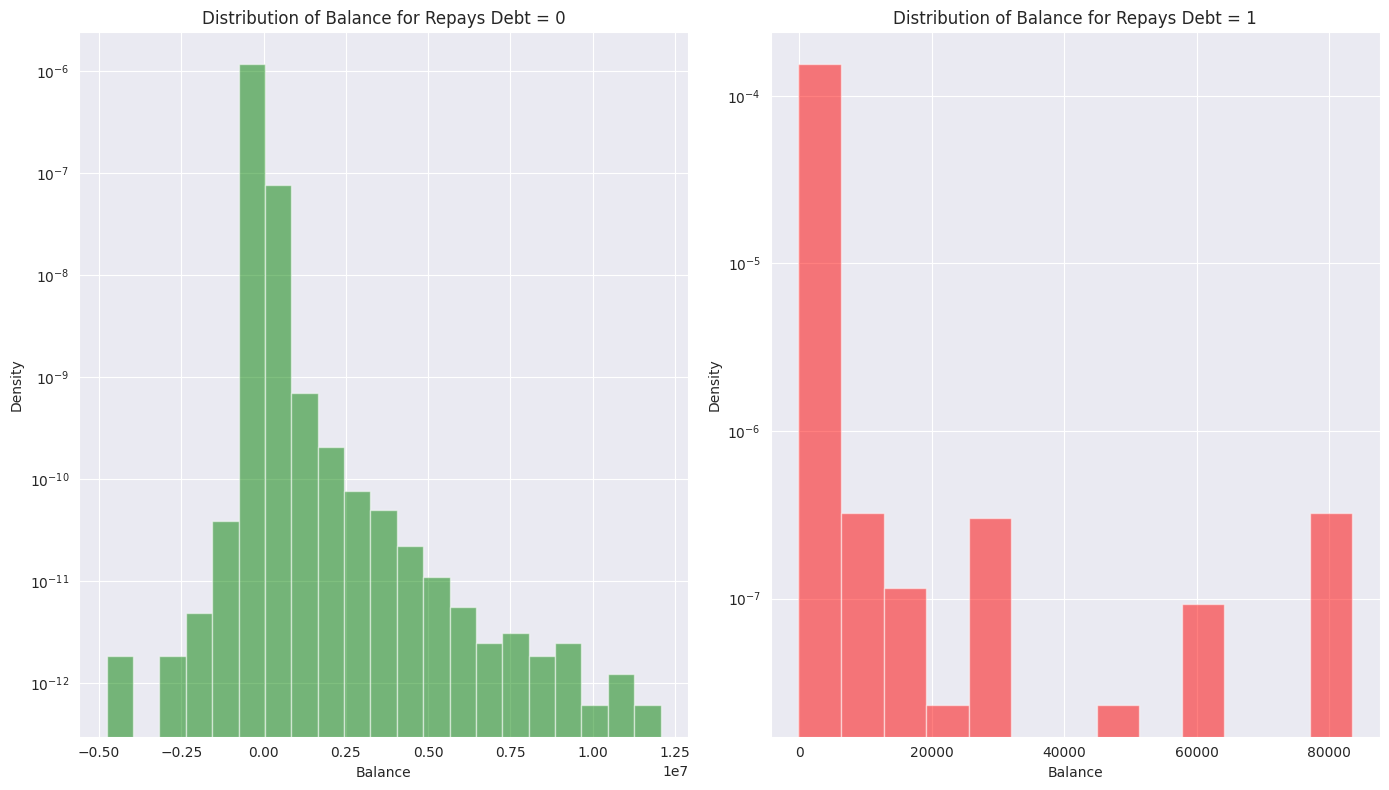

In [9]:
plt.figure(figsize=(14, 8))
colors = {0: "green", 1: "red"}
for i, val in enumerate(df['repays_debt'].unique()):
    subset = df[df['repays_debt'] == val]
    
    plt.subplot(1, 2, i + 1)
    plt.hist(subset['balance'], bins=int(np.log2(len(subset['balance']))) + 1, density=True, 
             alpha=0.5, color=colors[val], label=f'Repays Debt = {val}')
    
    plt.title(f'Distribution of Balance for Repays Debt = {val}')
    plt.xlabel('Balance')
    plt.ylabel('Density')
    plt.grid(True)
    plt.yscale('log')

plt.tight_layout()

plt.show()

For good clients, we observe a rather asymmetric distribution, with a significantly lower density of values around the zero balance compared to the other category. This suggests that the client's overall activity is variable over different periods and rarely remains at zero. This likely implies a positive correlation with repaying their debt.

For bad clients, the asymmetry is much more pronounced, and the range of values is also completely different. The number of balances around zero is two orders of magnitude higher compared to good clients. This leads us to believe that, across different periods, almost zero activity on their account is indicative of a bad client.

Additionally, we consistently observe that the classes are imbalanced.

Now, let's analyze the balance trend per period to evaluate our previous hypothesis.

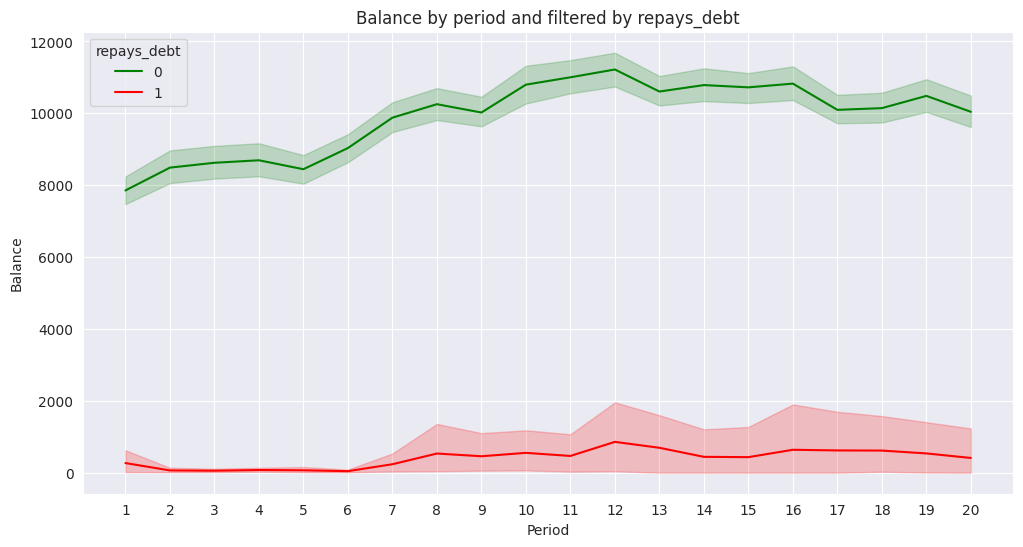

In [10]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='period', y='balance', hue='repays_debt', palette={0: 'green', 1: 'red'})

plt.xlabel('Period')
plt.ylabel('Balance')
plt.title('Balance by period and filtered by repays_debt')
plt.xticks(ticks=df['period'].unique())
plt.show()

For both good and bad clients, the balance trend fluctuates over time, although the range is clearly different. It's precisely the significant difference in range that could establish a decision criterion.

To further confirm our idea, let's proceed to analyze the trend of average balance over time and for each client category.

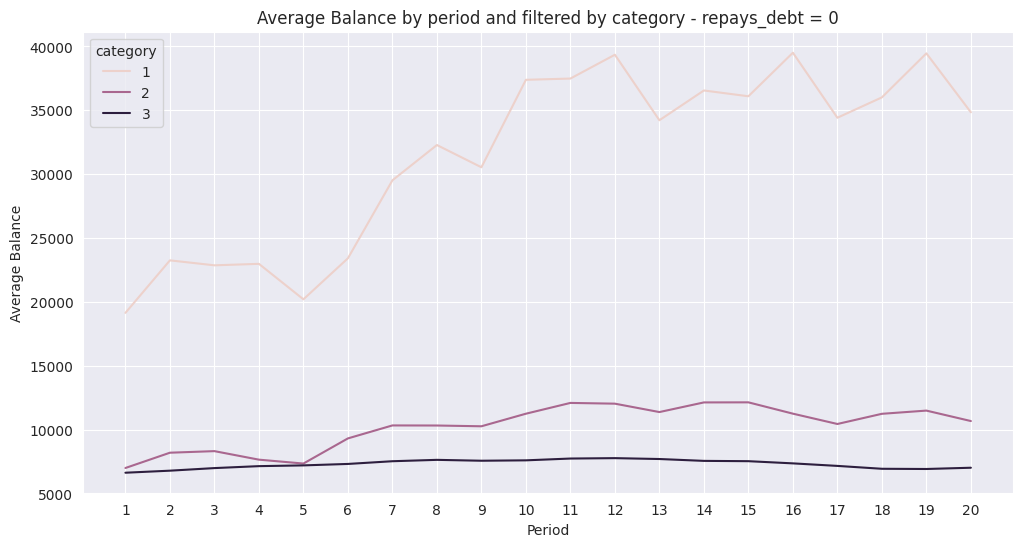

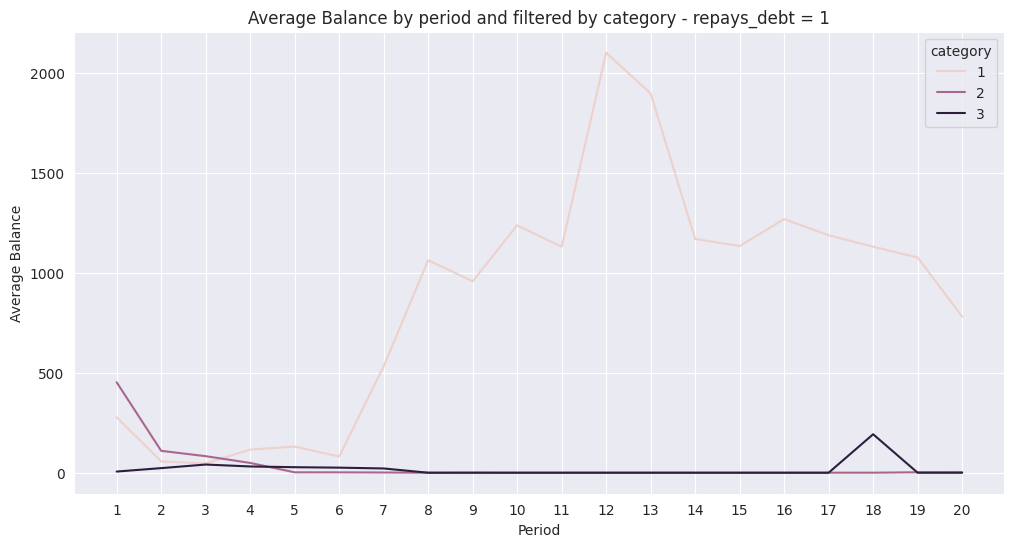

In [11]:
for val in df['repays_debt'].unique():
    df_filtered = df[df['repays_debt'] == val]

    # Average Balance for period and category
    average_balance = df_filtered.groupby(['period', 'category'])['balance'].mean().reset_index()
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=average_balance, x='period', y='balance', hue='category')

    plt.xlabel('Period')
    plt.ylabel('Average Balance')
    plt.title(f'Average Balance by period and filtered by category - repays_debt = {val}')
    plt.xticks(ticks=df['period'].unique()) 
    plt.show()

Our initial hypothesis is confirmed: even across different categories, if the balance remains at zero for various periods, the client will not be able to repay their debt. Category 1, which belongs to firm accounts, does not show a nearly zero balance, but it's an unusual balance for a firm account. Additionally, as mentioned earlier, the range is significantly different compared to good clients.

At this point, we wonder if belonging to a specific category implies a higher probability of repaying the debt.

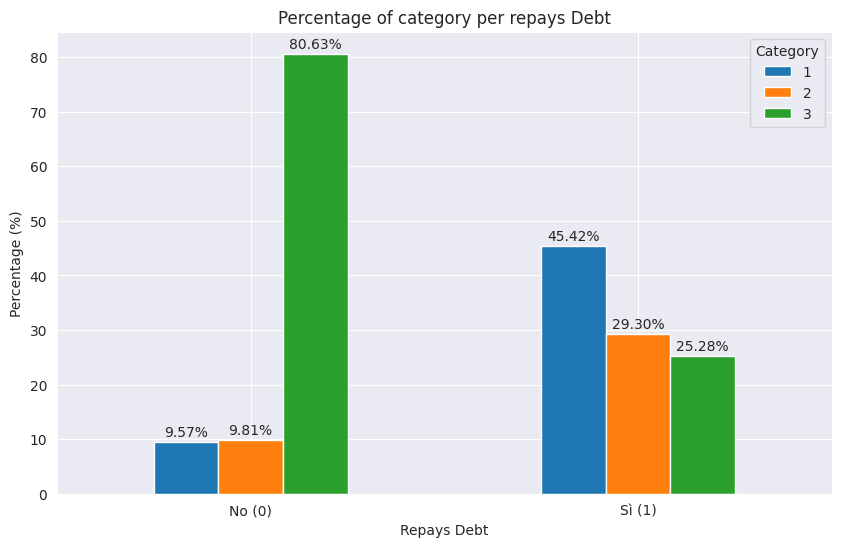

In [12]:
category_percentages = df.groupby('repays_debt')['category'].value_counts(normalize=True).unstack() * 100

ax = category_percentages.plot(kind='bar', figsize=(10, 6), rot=0)

plt.xlabel("Repays Debt")
plt.ylabel("Percentage (%)")
plt.title("Percentage of category per repays Debt")
plt.xticks(ticks=[0, 1], labels=['No (0)', 'Sì (1)'])
plt.legend(title='Category')

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2f}%', (x + width/2, y + height + 1), ha='center')

plt.show()

Keeping in mind that repays_debt=0 corresponds to a good client and repays_debt=1 corresponds to a bad client, we observe that:
- Good clients mostly belong to category 3. We could almost deduce a correlation between belonging to category 3 and being a good client.
- Bad clients, on the other hand, show a distribution without any significant peaks. Therefore, we can't draw any conclusions.

In [13]:
# Type Conversion for Dataset Columns
columns_tobe_bool = [f"product{i}" for i in range(1, 18)]
columns_tobe_bool.extend(['has_products', 'left_bank', 'joined_bank'])
df[columns_tobe_bool] = df[columns_tobe_bool].astype(bool)
df['category'] = df['category'].astype("category")

Per una visione di insieme si effettua una heatmap, ossia una matrice di correlazione lineare per individuare particolari legami tra le variabili numeriche

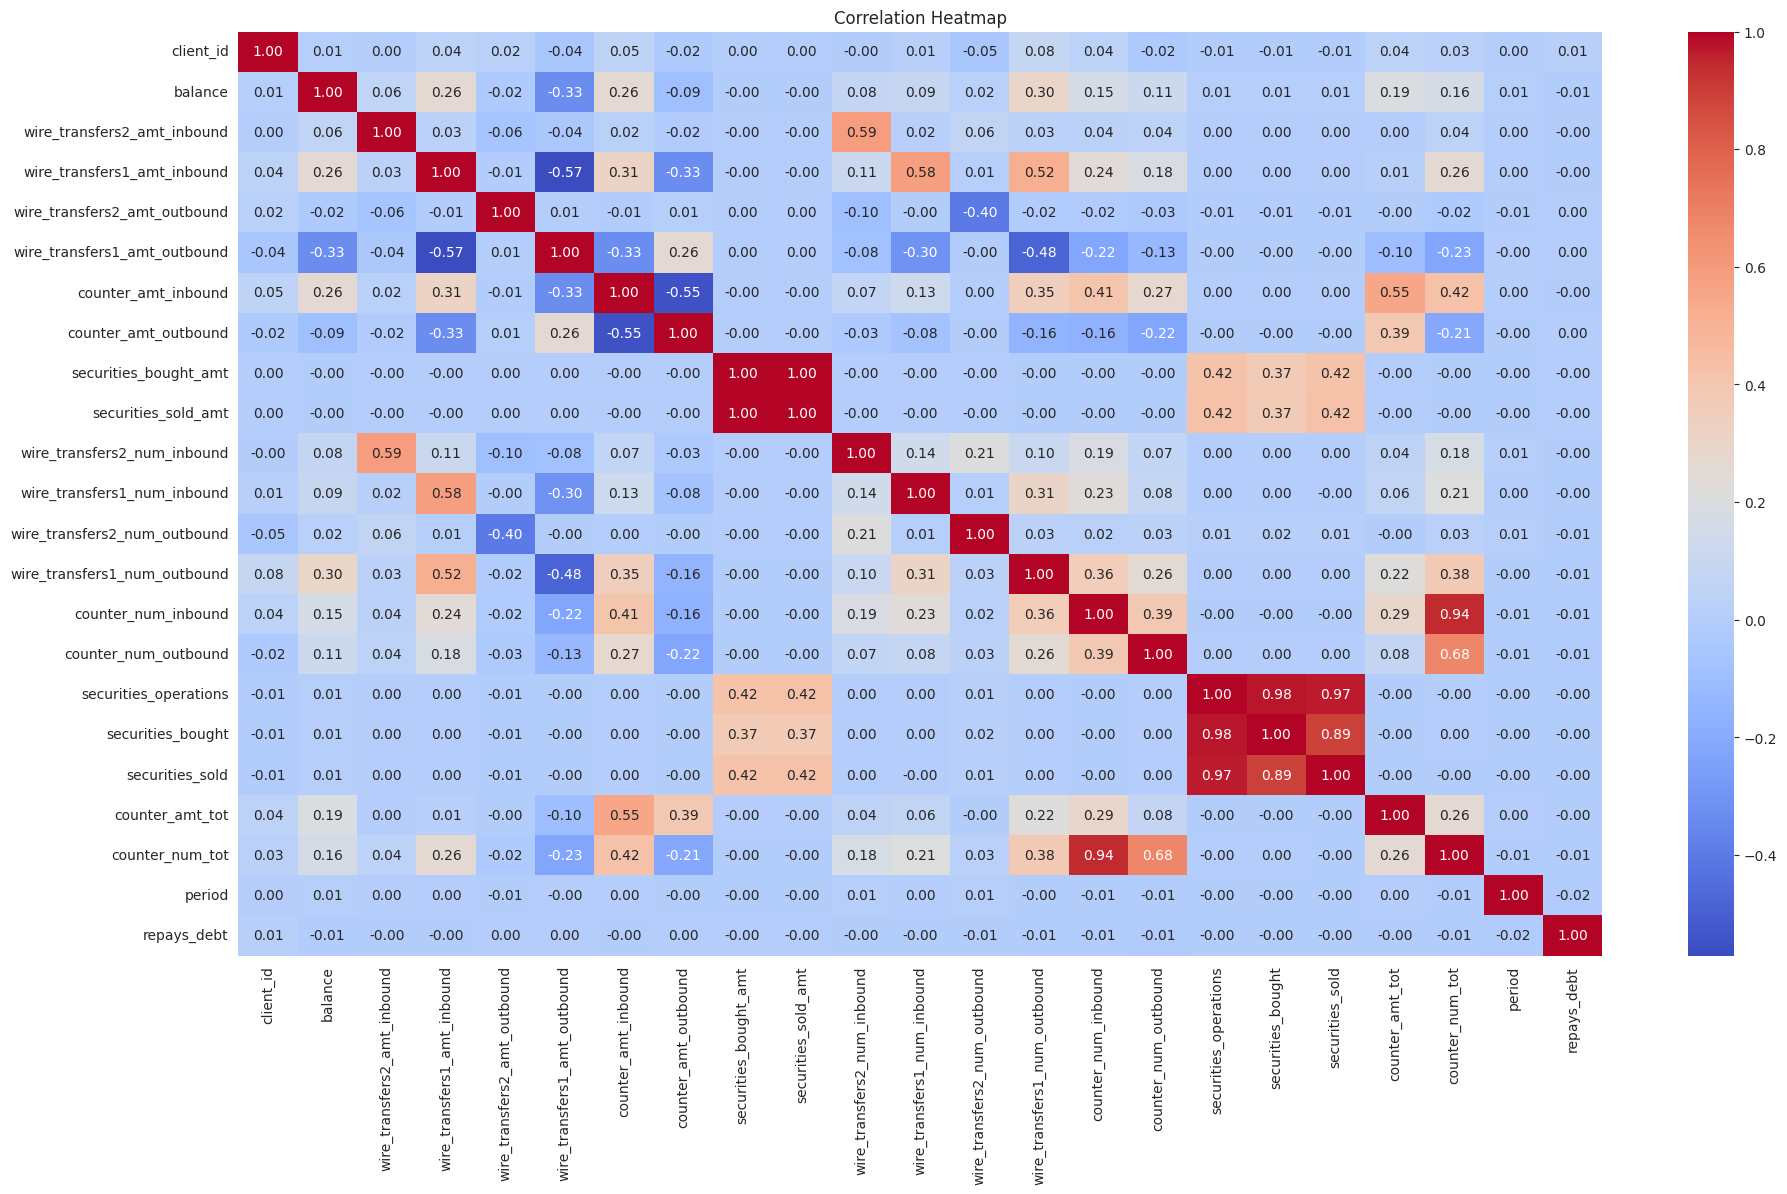

In [14]:
numeric_cols = df.select_dtypes(include=['number']).columns

correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(22, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

We print out the features with a correlation exceeding a certain threshold.

In [15]:
threshold = 0.7

upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

correlation_pairs = upper_triangle.stack().reset_index()
correlation_pairs.columns = ['Feature1', 'Feature2', 'Correlation']

strong_correlations = correlation_pairs[correlation_pairs['Correlation'].abs() > threshold]
strong_correlations = strong_correlations.sort_values(by='Correlation', ascending=False)

print("Most Correlated Features (with |Correlation| > {:.2f}):".format(threshold))
for index, row in strong_correlations.iterrows():
    print(f"{row['Feature1']} and {row['Feature2']}: {row['Correlation']:.2f}")

Most Correlated Features (with |Correlation| > 0.70):
securities_bought_amt and securities_sold_amt: 1.00
securities_operations and securities_bought: 0.98
securities_operations and securities_sold: 0.97
counter_num_inbound and counter_num_tot: 0.94
securities_bought and securities_sold: 0.89


No surprise there, it makes sense that the mentioned features have a strong correlation since they depend on each other.

# Data Preprocessing

In [16]:
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import f1_score, roc_curve, confusion_matrix, precision_recall_curve, accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

In [17]:
train_df = pd.read_csv('training.csv', engine="c")
test_df = pd.read_csv('test.csv', engine="c")

After performing one-hot encoding and preparing the training set, we proceed with data balancing. This is necessary because the size of one class is significantly larger than the other, so the resulting model wouldn't be able to distinguish the minority class. After this operation, the size of both classes will be the same.

Next, we remove rows with unknown target from the test set. This way, we can evaluate the model's performance on known data. Rows containing missing values are set aside to make predictions on them later (X_to_predict).

Finally, we standardize the data so that it falls within a reduced range of values, which the model can handle better.

In [18]:
train_data = pd.get_dummies(train_df, columns=['category', "period"], drop_first=True)
test_data = pd.get_dummies(test_df, columns=['category', "period"], drop_first=True)

# Train and target are separeted
X_train = train_data.drop('repays_debt', axis=1)
y_train = train_data['repays_debt']


undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# To evaluate the model, we only select rows for which there are no missing values. 
# Those with missing values, i.e. those for which predictions are to be made, are set aside.
X_test = test_data[test_data["repays_debt"] != "??"].drop(['repays_debt'], axis=1) 
y_test = test_data[test_data["repays_debt"] != "??"]["repays_debt"].reset_index(drop=True).astype(int)
X_to_predict = test_data[test_data["repays_debt"] == "??"].drop(['repays_debt'], axis=1) 

scaler = StandardScaler()
X_train_resampled_standard = scaler.fit_transform(X_train_resampled)
X_test_standard = scaler.transform(X_test)
X_to_predict_standard = scaler.transform(X_to_predict)

# Model Development

Initially, we conducted numerous trials with the SGDClassifier, but after several attempts, we decided to use an ensemble model: RandomForest. We initially trained this model without setting any hyperparameters, achieving an F1 score of 0.7092. Then after some trials we got our best, which give us an F1 score of 0.7188.

All the reported F2 scores are taken from the leaderbord.

In [23]:
###### F1 0.7092
# model = RandomForestClassifier(random_state=42)

# F1 0.7171 with period column dummy
# model = RandomForestClassifier(random_state=177, max_depth=50, max_features="log2", min_samples_split=6, n_estimators=800)

# F1 0.7188 with period column dummy
model = RandomForestClassifier(random_state=177, max_depth=70, max_features="log2", min_samples_split=9, n_estimators=1000)


# Try with period not dummy
# model = RandomForestClassifier(random_state=177, max_depth=90, max_features="sqrt", min_samples_split=9, n_estimators=1000)

model.fit(X_train_resampled_standard, y_train_resampled)
y_pred = model.predict(X_test_standard)
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

F1 Score: 0.7195366451325462


To improve the model's performance, we set up a gridsearch to find the best combination of hyperparameters. But unfortunately we could not achieve significantly better results.

In [21]:
# model = RandomForestClassifier(random_state=177)

# param_grid = {
#     'n_estimators': [800, 1000],
#     'max_features': ['sqrt', 'log2'],
#     'max_depth': [50, 55, 60],
#     'min_samples_split': [5, 6, 7],
# }

# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
#                            cv=6, n_jobs=-1, verbose=2, scoring='f1')

# grid_search.fit(X_train_resampled_standard, y_train_resampled)

# best_model = grid_search.best_estimator_
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# print("Best Parameters:", best_params)
# print("Best F1 Score:", best_score)

# y_pred = best_model.predict(X_test_standard)

# f1 = f1_score(y_test, y_pred)
# print(f'F1 Score on Test Set: {f1}')

Using the model itself, we proceed to check which features are most important.

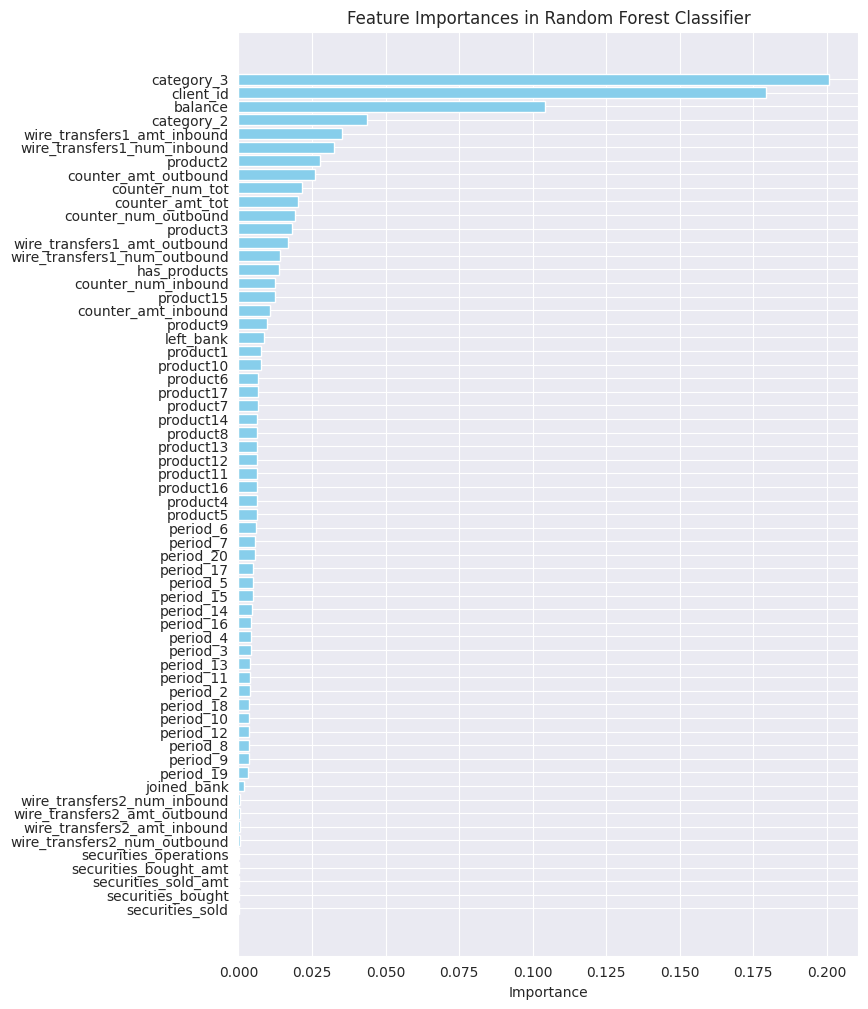

In [24]:
importances = model.feature_importances_
feature_names = X_train_resampled.columns
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 12))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances in Random Forest Classifier')
plt.yticks(fontsize=10)
plt.gca().invert_yaxis()
plt.show()

In [25]:
importances = model.feature_importances_
feature_names = X_train_resampled.columns
important_features = sorted(zip(importances, feature_names), reverse=True)
print("Important features:")
for importance, feature in important_features:
    if importance > 0.015:
        print(f"{feature}: {importance}")

Important features:
category_3: 0.20076629380709962
client_id: 0.17928930313822078
balance: 0.10424168572314513
category_2: 0.043759441163226664
wire_transfers1_amt_inbound: 0.035175227570706076
wire_transfers1_num_inbound: 0.0324929788586788
product2: 0.027864916782936396
counter_amt_outbound: 0.02610349172404138
counter_num_tot: 0.02164268276893476
counter_amt_tot: 0.020210400703701965
counter_num_outbound: 0.019055324393827615
product3: 0.018224849476672234
wire_transfers1_amt_outbound: 0.016769499694172203


Output features of the model with the best F1 score:

- category_3: 0.20076629380709962
- client_id: 0.17928930313822078
- balance: 0.10424168572314513
- category_2: 0.043759441163226664
- wire_transfers1_amt_inbound: 0.035175227570706076
- wire_transfers1_num_inbound: 0.0324929788586788
- product2: 0.027864916782936396
- counter_amt_outbound: 0.02610349172404138
- counter_num_tot: 0.02164268276893476
- counter_amt_tot: 0.020210400703701965
- counter_num_outbound: 0.019055324393827615
- product3: 0.018224849476672234
- wire_transfers1_amt_outbound: 0.016769499694172203


Comment:

- category_3 influences as previously imagined during the analysis. Indeed, we saw that those belonging to that category usually repay the debt.
- client_id: knowing the owner's creditworthiness a priori definitely provides insights into their chances of repaying the debt, without necessarily analyzing other characteristics. Therefore, the other characteristics associated with a random client hold less weight if linked to a client_id that we know will not repay the debt.
- balance, as expected, is the first numerical variable of major importance.

So far, our model has only been trained on a small part of the data because the classes are unbalanced. The following strategy is to use a set of Random Forests trained on different samples of the starting dataset, so that the classes are balanced but the data in the training are different each time. Finally, these models are put together using a VotingClassifier in ‘soft’ mode, so that better performance can be achieved by giving more weight to the most important votes.

Now we are going to apply the same transformation as before.

In [ ]:
train_data = pd.get_dummies(train_df, columns=['category', 'period'], drop_first=True)
test_data = pd.get_dummies(test_df, columns=['category', 'period'], drop_first=True)

X_train = train_data.drop('repays_debt', axis=1)
y_train = train_data['repays_debt']

X_test = test_data[test_data["repays_debt"] != "??"].drop(['repays_debt'], axis=1)
y_test = test_data[test_data["repays_debt"] != "??"]["repays_debt"].reset_index(drop=True).astype(int)
X_to_predict = test_data[test_data["repays_debt"] == "??"].drop(['repays_debt'], axis=1)

n_models = 8  # Number of models in the voting
models = []

for i in range(n_models):
    undersampler = RandomUnderSampler(random_state=42 + i)
    X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)
    
    scaler = StandardScaler()
    X_train_resampled_standard = scaler.fit_transform(X_train_resampled)
    
    # Use the Random Forest with the best parameters we obtain until now
    model = RandomForestClassifier(random_state=1177 + i, max_depth=70, max_features="log2", min_samples_split=9, n_estimators=1000)
    model.fit(X_train_resampled_standard, y_train_resampled)
    
    models.append(('rf' + str(i), model))

voting_clf = VotingClassifier(estimators=models, voting='soft')

voting_clf.fit(X_train_resampled_standard, y_train_resampled)

X_test_standard = scaler.transform(X_test)
X_to_predict_standard = scaler.transform(X_to_predict)

y_pred_test = voting_clf.predict(X_test_standard)
y_pred_to_predict = voting_clf.predict(X_to_predict_standard)

f1 = f1_score(y_test, y_pred_test)
print(f"F1 Score on Test Data: {f1}")

In [26]:
# Prediction of missing test set values
# y_to_send = model.predict(X_to_predict_standard)
y_to_send = pd.DataFrame(columns=["Label"], data=y_pred_to_predict)
y_to_send.to_csv('predictions.csv', index=False)

Despite the acceptable performance achieved previously, we proceed with another model that leverages boosting instead of bagging.

In [27]:
# 0.69 (Boosting - Gradient Boosting): {'learning_rate': 0.05, 'max_depth': 3, 'max_features': 'log2', 'n_estimators': 700, 'subsample': 0.8}

modelG = GradientBoostingClassifier(random_state=177, n_estimators=40,
    max_features='sqrt', max_depth=8,
    learning_rate=0.1,
    subsample=0.8)

modelG.fit(X_train_resampled_standard, y_train_resampled)
y_pred = modelG.predict(X_test_standard)
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

F1 Score: 0.7723440134907251


Unfortunately, the situation has not improved. The F1 level obtained has remained more or less constant.

In [28]:
y_to_send = modelG.predict(X_to_predict_standard)
y_to_send = pd.DataFrame(columns=["Label"], data=y_to_send)
# y_to_send.to_csv('predictions_40.csv', index=False)

# Task 2

Base on what we learned previously the most important features, according to the Random Forest, are:
- client_id
- category
- period

So, since now we have to predict always the same period as before but without actually knowing datas like balance, counter_num and others. We are going to build a new training set and of course a new test set, where there are only the most important columns mentioned before.

In [30]:
train_df_2 = pd.read_csv('training.csv', engine="c")
test_df_2 = pd.read_csv('test.csv', engine="c")

Keep only our columns

In [31]:
train_data_2 = train_df_2[["period", "category", "client_id", "repays_debt"]]
test_data_2 = test_df_2[["period", "category", "client_id", "repays_debt"]]

In [32]:
# Train and target are separeted
X_train_2 = train_data_2.drop('repays_debt', axis=1)
y_train_2 = train_data_2['repays_debt']

undersampler_2 = RandomUnderSampler(random_state=42) #, sampling_strategy=0.5)
X_train_resampled_2, y_train_resampled_2 = undersampler_2.fit_resample(X_train_2, y_train_2)

# To evaluate the model, we only select rows for which there are no missing values. 
# Those with missing values, i.e. those for which predictions are to be made, are set aside.
X_test_2 = test_data_2[test_data_2["repays_debt"] != "??"].drop(['repays_debt'], axis=1) 
y_test_2 = test_data_2[test_data_2["repays_debt"] != "??"]["repays_debt"].reset_index(drop=True).astype(int)
X_to_predict_2 = test_data_2[test_data_2["repays_debt"] == "??"].drop(['repays_debt'], axis=1) 


scaler_2 = StandardScaler()
X_train_resampled_standard_2 = scaler_2.fit_transform(X_train_resampled_2)
X_test_standard_2 = scaler_2.transform(X_test_2)
X_to_predict_standard_2 = scaler_2.transform(X_to_predict_2)

First we try always with the Random Forest, with the same hyperparameters as before.

In [33]:
model = RandomForestClassifier(random_state=177, max_depth=70, max_features="log2", min_samples_split=9, 
                               n_estimators=800, min_samples_leaf=2, n_jobs=-1)

model.fit(X_train_resampled_standard_2, y_train_resampled_2)
y_pred_2 = model.predict(X_test_standard_2)
f1 = f1_score(y_test_2, y_pred_2)
print(f'F1 Score: {f1}')

F1 Score: 0.4551769765133973


Having failed to achieve an acceptable result, we return to our initial choice using SGDClassifier. That is actually our better result.

In [34]:
# Best F1 score 0.6098
modelS = SGDClassifier(random_state=177, n_jobs=-1)

modelS.fit(X_train_resampled_standard_2, y_train_resampled_2)
y_pred_2 = modelS.predict(X_test_standard_2)
f1 = f1_score(y_test_2, y_pred_2)

print(f'F1 Score: {f1}')
#0.49165151264671847

F1 Score: 0.49165151264671847


In [35]:
y_to_send = modelS.predict(X_to_predict_standard_2)
y_to_send = pd.DataFrame(columns=["Label"], data=y_to_send)
y_to_send.to_csv('2predictions.csv', index=False)